In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import librosa
import soundfile as sf
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Real-time optimized configuration for SUBESCO
class SUBESCOConfig:
    # Audio parameters optimized for real-time
    SAMPLE_RATE = 16000  # Reduced from 48000 for speed
    TARGET_LENGTH = 5    # Reduced from 5 seconds
    TRIM_THRESHOLD = 25  # Slightly reduced
    MAX_AMPLITUDE = 0.9
    
    # Feature parameters optimized for real-time
    N_MFCC = 13         # Reduced from 60
    N_MELS = 30         # Reduced from 80  
    N_FRAMES = 500      # Reduced from 500
    
    NUM_CLASSES = 8
    EMOTIONS = ['Neutral', 'Angry', 'Sad', 'Happy', 'Surprised', 'Fear', 'Disappointment', 'Excitement']
    
    # Training parameters
    BATCH_SIZE = 32 #64
    LEARNING_RATE = 5e-4
    WEIGHT_DECAY = 5e-4
    NUM_EPOCHS = 60    # Reduced from 500
    PATIENCE = 25       # Reduced from 50

    # ADD: Enhanced regularization settings
    ENHANCED_DROPOUT = True
    REDUCED_LR = True
    EARLY_STOPPING = True
    
    DEVICE = torch.device('cuda')

config = SUBESCOConfig()

# Create directories
os.makedirs("subesco_augmented", exist_ok=True)
os.makedirs("subesco_processed", exist_ok=True)


In [21]:
# def load_subesco_dataset(dataset_path):
#     """Load SUBESCO dataset with filename parsing"""
#     paths = []
#     labels = []
    
#     # SUBESCO emotion mapping
#     emotion_map = {
#         'NEUTRAL': 'neutral',
#         'ANGRY': 'angry', 
#         'DISGUST': 'disgust',
#         'FEAR': 'fear',
#         'HAPPY': 'happy',
#         'SAD': 'sad',
#         'SURPRISE': 'surprise'
#     }
    
#     print("Loading SUBESCO dataset...")
    
#     for filename in os.listdir(dataset_path):
#         if filename.endswith('.wav'):
#             try:
#                 # Parse SUBESCO format: Gender_SpeakerNum_SpeakerName_S_SentenceNum_Emotion_Take_RepeatNum.wav
#                 # Example: F_12_TITHI_S_10_SURPRISE_TAKE_5.wav
#                 parts = filename.replace('.wav', '').split('_')
                
#                 if len(parts) >= 7:
#                     emotion_name = parts[5].upper()  # SURPRISE, ANGER, etc.
                    
#                     if emotion_name in emotion_map:
#                         full_path = os.path.join(dataset_path, filename)
#                         paths.append(full_path)
#                         labels.append(emotion_map[emotion_name])
                        
#             except Exception as e:
#                 print(f"Error parsing {filename}: {e}")
#                 continue
    
#     print(f"Loaded {len(paths)} files from SUBESCO")
    
#     # Print distribution
#     label_counts = Counter(labels)
#     print("Original SUBESCO distribution:")
#     for emotion in config.EMOTIONS:
#         emotion_lower = emotion.lower()
#         count = label_counts.get(emotion_lower, 0)
#         print(f"  {emotion}: {count}")
    
#     return paths, labels
# def load_combined_dataset(subesco_path, banglaMOOD_path=None):  # Changed parameter name
#     """
#     Load SUBESCO (all 7 emotions) + BanSpEmo (6 emotions) 
#     Same function signature as your existing function
#     """
    
#     all_paths = []
#     all_labels = []
    
#     # Load SUBESCO dataset (all 7 emotions) - no changes
#     print("Loading SUBESCO dataset (all 7 emotions)...")
#     subesco_paths, subesco_labels = load_subesco_dataset(subesco_path)
#     all_paths.extend(subesco_paths)
#     all_labels.extend(subesco_labels)
    
#     if banglaMOOD_path and os.path.exists(banglaMOOD_path):
#         print("Loading BanglaMOOD dataset...")
#         banglaMOOD_paths, banglaMOOD_labels = load_banglamood_dataset(banglaMOOD_path)  # CHANGED
#         all_paths.extend(banglaMOOD_paths)
#         all_labels.extend(banglaMOOD_labels)
#         print(f"Added {len(banglaMOOD_paths)} BanSpEmo files")
    
#     # Print combined distribution
#     label_counts = Counter(all_labels)
#     print(f"Combined dataset loaded: {len(all_paths)} files")
#     print("Combined distribution:")
#     for emotion in config.EMOTIONS:
#         emotion_lower = emotion.lower()
#         count = label_counts.get(emotion_lower, 0)
#         source = "SUBESCO only" if emotion_lower == 'neutral' else "SUBESCO + BanSpEmo"
#         print(f"  {emotion}: {count} ({source})")
    
#     return all_paths, all_labels

def load_combined_dataset(subesco_path, banglaMOOD_path=None, kbes_path=None):
    """
    Load SUBESCO (all 7 emotions) + BanglaMOOD (6 emotions) + KBES (5 emotions)
    """
    
    all_paths = []
    all_labels = []
    
    # Load SUBESCO dataset (all 7 emotions)
    print("Loading SUBESCO dataset (all 7 emotions)...")
    subesco_paths, subesco_labels = load_subesco_dataset(subesco_path)
    all_paths.extend(subesco_paths)
    all_labels.extend(subesco_labels)
    
    # Load BanglaMOOD dataset if provided
    if banglaMOOD_path and os.path.exists(banglaMOOD_path):
        print("Loading BanglaMOOD dataset...")
        banglaMOOD_paths, banglaMOOD_labels = load_banglamood_dataset(banglaMOOD_path)
        all_paths.extend(banglaMOOD_paths)
        all_labels.extend(banglaMOOD_labels)
        print(f"Added {len(banglaMOOD_paths)} BanglaMOOD files")
    
    # Load KBES dataset if provided
    if kbes_path and os.path.exists(kbes_path):
        print("Loading KBES dataset...")
        kbes_paths, kbes_labels = load_kbes_dataset(kbes_path)
        all_paths.extend(kbes_paths)
        all_labels.extend(kbes_labels)
        print(f"Added {len(kbes_paths)} KBES files")
    
    # Print combined distribution
    label_counts = Counter(all_labels)
    print(f"Combined dataset loaded: {len(all_paths)} files")
    print("Combined distribution:")
    
    for emotion in config.EMOTIONS:
        emotion_lower = emotion.lower()
        count = label_counts.get(emotion_lower, 0)
        
        # Determine source information
        sources = []
        if emotion_lower in ['neutral', 'angry', 'disappointment', 'fear', 'happy', 'sad', 'surprised']:
            sources.append("SUBESCO")
        if emotion_lower in ['happy', 'sad', 'angry', 'neutral', 'surprised', 'fear', 'excitement', 'disappointment']:
            sources.append("BanglaMOOD")
        if emotion_lower in ['angry', 'disappointment', 'happy', 'neutral', 'sad']:
            sources.append("KBES")
        
        source_info = " + ".join(sources) if sources else "None"
        print(f"  {emotion}: {count} ({source_info})")
    
    return all_paths, all_labels



def load_subesco_dataset(dataset_path):
    """Your existing SUBESCO loader - no changes needed"""
    paths = []
    labels = []
    
    # Keep all 7 SUBESCO emotions
    emotion_map = {
        'NEUTRAL': 'neutral',
        'ANGRY': 'angry', 
        'DISGUST': 'disappointment',    # Keep this
        'FEAR': 'fear',          # Keep this
        'HAPPY': 'happy',
        'SAD': 'sad',
        'SURPRISE': 'surprised'
    }
    
    print("Loading SUBESCO dataset (all 7 emotions)...")
    
    for filename in os.listdir(dataset_path):
        if filename.endswith('.wav'):
            try:
                parts = filename.replace('.wav', '').split('_')
                if len(parts) >= 7:
                    emotion_name = parts[5].upper()
                    
                    if emotion_name in emotion_map:
                        full_path = os.path.join(dataset_path, filename)
                        paths.append(full_path)
                        labels.append(emotion_map[emotion_name])
                        
            except Exception as e:
                continue
    
    return paths, labels

# def load_banspemo_dataset(dataset_path):
#     """Load BanSpEmo dataset with CORRECT 5-component filename parsing"""
#     paths = []
#     labels = []
    
#     # BanSpEmo emotion mapping (same as before)
#     banspemo_emotion_map = {
#         '01': 'angry',     # Anger
#         '02': 'disgust',   # Disgust
#         '03': 'fear',      # Fear
#         '04': 'happy', # Happy
#         '05': 'sad',   # Sad
#         '06': 'surprise'   # Surprised
#     }
    
#     print("Loading BanSpEmo dataset...")
#     found_emotions = Counter()
#     parsed_count = 0
#     total_count = 0
    
#     for filename in os.listdir(dataset_path):
#         if filename.endswith('.wav'):
#             total_count += 1
#             try:
#                 # Parse BanSpEmo ACTUAL 5-component structure
#                 base_name = filename.replace('.wav', '')
#                 parts = base_name.split('_')
                
#                 if len(parts) == 5:  # CORRECTED: 5 components, not 6
#                     sentence_set = parts[0]    # ss1, ss2
#                     sentence_num = parts[1]    # s1, s2, s3...
#                     speaker_number = parts[2]  # sp1, sp2, sp3...
#                     speaker_gender = parts[3]  # m, f
#                     emotion_code = parts[4]    # 01-06
                    
#                     found_emotions[emotion_code] += 1
                    
#                     if emotion_code in banspemo_emotion_map:
#                         full_path = os.path.join(dataset_path, filename)
#                         paths.append(full_path)
#                         labels.append(banspemo_emotion_map[emotion_code])
#                         parsed_count += 1
#                 else:
#                     print(f"Unexpected filename format: {filename} ({len(parts)} parts, expected 5)")
                        
#             except Exception as e:
#                 print(f"Error parsing {filename}: {e}")
#                 continue
    
#     # Debug output
#     print(f"BanSpEmo parsing results:")
#     print(f"  Total WAV files: {total_count}")
#     print(f"  Successfully parsed: {parsed_count}")
#     print(f"  Parse success rate: {parsed_count/total_count*100:.1f}%")
    
#     print("\nEmotion distribution:")
#     for code, count in sorted(found_emotions.items()):
#         emotion_name = banspemo_emotion_map.get(code, "UNKNOWN")
#         print(f"  Code {code} ({emotion_name}): {count} files")
    
#     return paths, labels

def load_banglamood_dataset(dataset_path):
    """Load your BanglaMOOD dataset: EmotionFolder -> AudioFile.wav"""
    paths = []
    labels = []
    
    # BanglaMOOD emotion mapping
    banglamood_emotion_map = {
        'happy': 'happy',
        'sad': 'sad', 
        'angry': 'angry',
        'neutral': 'neutral',
        'surprised': 'surprised',
        'fear': 'fear',
        'excitement': 'excitement',
        'disappointment': 'disappointment'  # Will map to 'disgust' in final processing
    }
    
    print("Loading BanglaMOOD dataset...")
    
    for emotion_dir in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_dir)
        
        if os.path.isdir(emotion_path):
            emotion_name = emotion_dir.lower()
            
            if emotion_name in banglamood_emotion_map:
                # Get all WAV files directly from emotion folder
                for filename in os.listdir(emotion_path):
                    if filename.endswith('.wav'):
                        full_path = os.path.join(emotion_path, filename)
                        paths.append(full_path)
                        labels.append(banglamood_emotion_map[emotion_name])
    
    print(f"Loaded {len(paths)} BanglaMOOD files")
    return paths, labels

def load_kbes_dataset(dataset_path):
    """
    Load KBES dataset: EmotionFolder(High/Low) -> audio.wav files
    """
    paths = []
    labels = []
    
    # KBES emotion mapping (handling intensity levels)
    kbes_emotion_map = {
        'angry (high)': 'angry',
        'angry (low)': 'angry',
        'disgust (high)': 'disappointment',  # Map to disappointment like SUBESCO
        'disgust (low)': 'disappointment',
        'happy (high)': 'happy', 
        'happy (low)': 'happy',
        'neutral': 'neutral',
        'sad (high)': 'sad',
        'sad (low)': 'sad'
    }
    
    print("Loading KBES dataset...")
    
    for emotion_dir in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_dir)
        
        if os.path.isdir(emotion_path):
            emotion_name = emotion_dir.lower()
            
            if emotion_name in kbes_emotion_map:
                # Get all WAV files from emotion folder
                for filename in os.listdir(emotion_path):
                    if filename.endswith('.wav'):
                        full_path = os.path.join(emotion_path, filename)
                        paths.append(full_path)
                        labels.append(kbes_emotion_map[emotion_name])
    
    print(f"Loaded {len(paths)} KBES files")
    return paths, labels



In [22]:
def standardize_audio_realtime(file_path, target_length=config.TARGET_LENGTH, 
                              sample_rate=config.SAMPLE_RATE, 
                              trim_threshold=config.TRIM_THRESHOLD, 
                              max_amplitude=config.MAX_AMPLITUDE):
    """Optimized audio standardization for real-time performance"""
    try:
        # Load audio with optimized sample rate
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Standardize length
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        
        # Quick trim and re-pad
        waveform, _ = librosa.effects.trim(waveform, top_db=trim_threshold)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]  # Ensure exact length
        
        # Normalize volume
        if waveform.max() > 0:
            waveform = waveform / waveform.max() * max_amplitude
        
        return waveform, sr
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        # Return silence if file fails
        return np.zeros(int(target_length * sample_rate)), sample_rate


In [23]:
def augment_combined_realtime(paths, labels, target_count=300, 
                             augmented_base_path="combined_augmented"):
    """
    Augment all 7 emotions to target_count
    Same function signature as your existing function
    """
    
    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original combined dataset")
        return paths, labels
    
    print(f"Starting combined dataset augmentation to {target_count} samples per emotion...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    # Process all 7 emotions
    for emotion_lower in ['neutral', 'angry', 'disappointment', 'fear', 'happy', 'sad', 'surprised', 'excitement']:
        emotion_title = emotion_lower.title()
        original_count = label_counts.get(emotion_lower, 0)
        source_info = ""
        
        if emotion_lower in ['disgust', 'fear']:
            source_info = " (SUBESCO only)"
        else:
            source_info = " (SUBESCO + BanglaMOOD)"
            
        print(f"{emotion_title}: {original_count} original samples{source_info}")
        
        if original_count == 0:
            print(f"  Warning: No samples found for {emotion_title}")
            continue
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Combine original and existing augmented
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Augmentation strategy based on emotion
        if emotion_lower in ['disgust', 'fear']:
            # More aggressive augmentation for SUBESCO-only emotions
            aug_types = ["pitch_1", "pitch_neg_1", "pitch_2", "pitch_neg_2", 
                        "stretch_1.05", "stretch_1.1", "stretch_0.95", "stretch_0.9",
                        "noise_0.005", "noise_0.008"]
        else:
            # Standard augmentation for combined emotions
            aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "stretch_0.9", "noise_0.005"]
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 3:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation (same logic as your existing code)
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        final_count = len([l for l in all_labels if l == emotion_lower])
        print(f"  Final count for {emotion_title}: {final_count}")
    
    print(f"Total augmented samples: {len(all_paths)} ({len(all_paths)//7} per emotion)")
    return all_paths, all_labels

def augment_subesco_realtime(paths, labels, target_count=300, 
                            augmented_base_path="subesco_augmented"):
    """Optimized augmentation for SUBESCO with real-time considerations"""

    # Handle no augmentation case
    if target_count is None or target_count == 0:
        print("No augmentation requested - using original dataset only")
        return paths, labels
    
    print("Starting SUBESCO augmentation (real-time optimized)...")
    label_counts = Counter(labels)
    all_paths, all_labels = [], []
    
    for emotion_lower in set(labels):
        emotion_title = emotion_lower.title()
        original_count = label_counts[emotion_lower]
        print(f"{emotion_title}: {original_count} original samples")
        
        # Create directory for this emotion
        label_dir = os.path.join(augmented_base_path, emotion_lower)
        os.makedirs(label_dir, exist_ok=True)
        
        # Get paths for this emotion
        label_paths = [p for p, l in zip(paths, labels) if l == emotion_lower]
        
        # Check existing augmented files
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Using existing {total_current} samples for {emotion_title}")
            # Use existing files
            combined_paths = label_paths + [os.path.join(label_dir, f) for f in existing_files]
            combined_labels = [emotion_lower] * len(combined_paths)
            
            # Randomly select target_count samples
            if len(combined_paths) > target_count:
                indices = np.random.choice(len(combined_paths), target_count, replace=False)
                selected_paths = [combined_paths[i] for i in indices]
                selected_labels = [combined_labels[i] for i in indices]
            else:
                selected_paths = combined_paths
                selected_labels = combined_labels
                
            all_paths.extend(selected_paths)
            all_labels.extend(selected_labels)
            continue
        
        # Clear existing and create new augmentations
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        
        needed = target_count - original_count
        print(f"  Need to generate {needed} augmented samples for {emotion_title}")
        
        # Reduced augmentation types for speed
        aug_types = ["pitch_1", "pitch_neg_1", "stretch_1.1", "noise_0.005", "stretch_0.9"]
        
        # Extra augmentations for challenging emotions
        if emotion_lower in ["disgust", "fear", "surprise"]:  # SUBESCO challenging classes
            aug_types.extend(["pitch_2", "pitch_neg_2", "noise_0.008"])
        
        aug_paths, aug_labels = [], []
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 2:  # Prevent infinite loop
            orig_idx = aug_idx % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            
            try:
                waveform, sr = standardize_audio_realtime(label_paths[orig_idx])
                base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
                
                # Apply augmentation
                if aug_type.startswith("pitch"):
                    if "neg" in aug_type:
                        n_steps = -float(aug_type.split("_")[2])
                    else:
                        n_steps = float(aug_type.split("_")[1])
                    augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                    file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("stretch"):
                    rate = float(aug_type.split("_")[1])
                    augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                    # Ensure consistent length after stretching
                    target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                    if len(augmented) < target_samples:
                        augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                    else:
                        augmented = augmented[:target_samples]
                    file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                    
                elif aug_type.startswith("noise"):
                    noise_level = float(aug_type.split("_")[1])
                    noise = np.random.normal(0, noise_level, waveform.shape)
                    augmented = waveform + noise
                    file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
                
                # Save augmented file
                aug_path = os.path.join(label_dir, file_name)
                sf.write(aug_path, augmented, sr)
                aug_paths.append(aug_path)
                aug_labels.append(emotion_lower)
                needed -= 1
                
            except Exception as e:
                print(f"  Augmentation error: {e}")
            
            aug_idx += 1
        
        # Combine original and augmented
        combined_paths = label_paths + aug_paths
        combined_labels = [emotion_lower] * len(combined_paths)
        
        # Select target_count samples
        if len(combined_paths) > target_count:
            indices = np.random.choice(len(combined_paths), target_count, replace=False)
            selected_paths = [combined_paths[i] for i in indices]
            selected_labels = [combined_labels[i] for i in indices]
        else:
            selected_paths = combined_paths
            selected_labels = combined_labels
        
        all_paths.extend(selected_paths)
        all_labels.extend(selected_labels)
        
        print(f"  Final count for {emotion_title}: {len([l for l in all_labels if l == emotion_lower])}")
    
    print(f"Total augmented samples: {len(all_paths)}")
    return all_paths, all_labels

def augment_excitement_only(paths, labels, target_excitement_count=900, 
                           augmented_base_path="excitement_augmented"):
    """
    Augment only excitement emotion to target count while keeping other emotions unchanged
    
    Args:
        paths: List of audio file paths
        labels: List of corresponding emotion labels
        target_excitement_count: Number of excitement samples to target (default 900)
        augmented_base_path: Base directory for saving augmented files
    
    Returns:
        updated_paths, updated_labels: Lists with augmented excitement samples included
    """
    
    print(f"Starting excitement-only augmentation to {target_excitement_count} samples...")
    
    # Separate excitement from other emotions
    excitement_paths = [p for p, l in zip(paths, labels) if l == 'excitement']
    excitement_labels = ['excitement'] * len(excitement_paths)
    other_paths = [p for p, l in zip(paths, labels) if l != 'excitement']
    other_labels = [l for l in labels if l != 'excitement']
    
    original_excitement_count = len(excitement_paths)
    print(f"Original excitement samples: {original_excitement_count}")
    print(f"Other emotion samples: {len(other_paths)}")
    
    # Create excitement augmentation directory
    excitement_dir = os.path.join(augmented_base_path, 'excitement')
    os.makedirs(excitement_dir, exist_ok=True)
    
    # Check if we need augmentation
    if original_excitement_count >= target_excitement_count:
        print(f"No augmentation needed - already have {original_excitement_count} excitement samples")
        return paths, labels
    
    # Clear existing augmented files
    existing_files = [f for f in os.listdir(excitement_dir) if f.endswith(".wav")]
    for f in existing_files:
        os.remove(os.path.join(excitement_dir, f))
    
    needed = target_excitement_count - original_excitement_count
    print(f"Need to generate {needed} augmented excitement samples")
    
    # Aggressive augmentation types for excitement
    aug_types = [
        "pitch_1", "pitch_neg_1", "pitch_1.5", "pitch_neg_1.5", "pitch_2", "pitch_neg_2",
        "stretch_1.05", "stretch_1.1", "stretch_1.15", "stretch_0.95", "stretch_0.9", "stretch_0.85",
        "noise_0.003", "noise_0.005", "noise_0.008", "noise_0.01"
    ]
    
    augmented_excitement_paths = []
    aug_idx = 0
    
    while needed > 0 and aug_idx < target_excitement_count * 3:  # Prevent infinite loop
        orig_idx = aug_idx % len(excitement_paths)
        aug_type = aug_types[aug_idx % len(aug_types)]
        
        try:
            # Load and standardize audio (using your existing function)
            waveform, sr = standardize_audio_realtime(excitement_paths[orig_idx])
            base_name = os.path.basename(excitement_paths[orig_idx]).replace(".wav", "")
            
            # Apply augmentation based on type
            if aug_type.startswith("pitch"):
                if "neg" in aug_type:
                    n_steps = -float(aug_type.split("_")[2])
                else:
                    n_steps = float(aug_type.split("_")[1])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                # Ensure consistent length after stretching
                target_samples = int(config.TARGET_LENGTH * config.SAMPLE_RATE)
                if len(augmented) < target_samples:
                    augmented = np.pad(augmented, (0, target_samples - len(augmented)), mode='constant')
                else:
                    augmented = augmented[:target_samples]
                file_name = f"{base_name}_stretch_{rate}_{aug_idx:03d}.wav"
                
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx:03d}.wav"
            
            # Save augmented file
            aug_path = os.path.join(excitement_dir, file_name)
            sf.write(aug_path, augmented, sr)
            augmented_excitement_paths.append(aug_path)
            needed -= 1
            
            if aug_idx % 50 == 0:  # Progress indicator
                print(f"  Generated {len(augmented_excitement_paths)} augmented samples...")
                
        except Exception as e:
            print(f"  Augmentation error for {excitement_paths[orig_idx]}: {e}")
        
        aug_idx += 1
    
    # Combine all paths and labels
    final_excitement_paths = excitement_paths + augmented_excitement_paths
    final_excitement_labels = ['excitement'] * len(final_excitement_paths)
    
    # If we generated more than needed, randomly select target count
    if len(final_excitement_paths) > target_excitement_count:
        indices = np.random.choice(len(final_excitement_paths), target_excitement_count, replace=False)
        final_excitement_paths = [final_excitement_paths[i] for i in indices]
        final_excitement_labels = [final_excitement_labels[i] for i in indices]
    
    # Combine with other emotions
    updated_paths = other_paths + final_excitement_paths
    updated_labels = other_labels + final_excitement_labels
    
    # Final summary
    final_counts = Counter(updated_labels)
    print(f"\nFinal dataset composition:")
    for emotion, count in sorted(final_counts.items()):
        print(f"  {emotion}: {count} samples")
    
    print(f"Total samples: {len(updated_paths)}")
    print(f"Excitement augmentation complete!")
    
    return updated_paths, updated_labels


In [24]:
def extract_enhanced_realtime_features(file_path, sample_rate=config.SAMPLE_RATE, 
                                     n_mfcc=config.N_MFCC, n_mels=config.N_MELS, 
                                     n_frames=config.N_FRAMES):
    """Enhanced feature extraction targeting emotion-specific characteristics"""
    
    try:
        # Load with optimized parameters
        waveform, sr = librosa.load(file_path, sr=sample_rate, mono=True)
        
        # Calculate hop length for consistent frames
        hop_length = len(waveform) // (n_frames - 1) if n_frames > 1 else len(waveform) // 100
        hop_length = max(hop_length, 64)
        
        # ✅ CORE FEATURES (Your existing ones)
        mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        
        mel_spec = librosa.feature.melspectrogram(
            y=waveform, sr=sr, n_mels=n_mels, hop_length=hop_length, fmax=sr//2
        )
        log_mel = librosa.power_to_db(mel_spec, ref=np.max)
        
        # ✅ ENHANCED SPECTRAL FEATURES (Critical for emotion discrimination)
        spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr, hop_length=hop_length)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr, hop_length=hop_length)
        spectral_contrast = librosa.feature.spectral_contrast(y=waveform, sr=sr, hop_length=hop_length)  # 7 bands
        spectral_flatness = librosa.feature.spectral_flatness(y=waveform, hop_length=hop_length)
        
        # ✅ PROSODIC FEATURES (Excellent for excitement/neutral/sad discrimination)
        # Pitch/F0 features
        f0 = librosa.yin(waveform, fmin=50, fmax=400, hop_length=hop_length)
        f0_filled = np.nan_to_num(f0)  # Replace NaN with 0
        
        # Pitch statistics (critical for emotion)
        pitch_mean = np.full((1, len(f0_filled)), np.mean(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
        pitch_std = np.full((1, len(f0_filled)), np.std(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
        pitch_range = np.full((1, len(f0_filled)), np.ptp(f0_filled[f0_filled > 0]) if np.any(f0_filled > 0) else 0)
        
        # ✅ TEMPORAL DYNAMICS (Helps with fear/anger vs neutral/sad)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(waveform, hop_length=hop_length)
        
        # Energy/RMS features
        rms_energy = librosa.feature.rms(y=waveform, hop_length=hop_length)
        
        # Tempo and rhythm (good for excitement vs other emotions)
        try:
            tempo, beats = librosa.beat.beat_track(y=waveform, sr=sr, hop_length=hop_length)
            tempo_feature = np.full((1, n_frames), tempo)
        except:
            tempo_feature = np.zeros((1, n_frames))
        
        # ✅ CHROMAGRAM (Helps with musical/tonal content)
        chroma = librosa.feature.chroma_stft(y=waveform, sr=sr, hop_length=hop_length)  # 12 features
        
        def pad_or_trim(feature, target_frames):
            if feature.shape[1] < target_frames:
                pad_width = target_frames - feature.shape[1]
                feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
            else:
                feature = feature[:, :target_frames]
            return feature
        
        # Pad/trim all features to consistent frames
        features_to_combine = [
            pad_or_trim(mfcc, n_frames),                    # 20 features
            pad_or_trim(log_mel, n_frames),                 # 30 features
            pad_or_trim(spectral_centroid, n_frames),       # 1 feature
            pad_or_trim(spectral_rolloff, n_frames),        # 1 feature  
            pad_or_trim(spectral_bandwidth, n_frames),      # 1 feature
            pad_or_trim(spectral_contrast, n_frames),       # 7 features
            pad_or_trim(spectral_flatness, n_frames),       # 1 feature
            pad_or_trim(f0_filled.reshape(1, -1), n_frames), # 1 feature
            pad_or_trim(pitch_mean, n_frames),              # 1 feature
            pad_or_trim(pitch_std, n_frames),               # 1 feature
            pad_or_trim(pitch_range, n_frames),             # 1 feature
            pad_or_trim(zero_crossing_rate, n_frames),      # 1 feature
            pad_or_trim(rms_energy, n_frames),              # 1 feature
            pad_or_trim(tempo_feature, n_frames),           # 1 feature
            pad_or_trim(chroma, n_frames)                   # 12 features
        ]
        
        # Combine all features: Total = 20+30+1+1+1+7+1+1+1+1+1+1+1+1+12 = 80 features
        combined_features = np.concatenate(features_to_combine, axis=0)
        
        return combined_features  # Shape: (80, n_frames)
        
    except Exception as e:
        print(f"Enhanced feature extraction error for {file_path}: {e}")
        # Return dummy features if extraction fails  
        n_total_features = 80  # Updated total
        return np.zeros((n_total_features, n_frames))


def compute_features_batch(paths, batch_size=100):
    """Batch processing for faster feature computation"""
    features = []
    total_batches = (len(paths) + batch_size - 1) // batch_size
    
    print(f"Computing features for {len(paths)} files in {total_batches} batches...")
    
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_features = []
        
        for j, file_path in enumerate(batch_paths):
            if (i + j) % 200 == 0:
                print(f"  Processed {i + j}/{len(paths)} files...")
            
            feat = extract_enhanced_realtime_features(file_path)
            batch_features.append(feat)
        
        features.extend(batch_features)
        
        # Clear memory periodically
        if i % (batch_size * 10) == 0:
            import gc
            gc.collect()
    
    print("Feature extraction completed!")
    return features


In [45]:
class RealtimeCNNTransformer(nn.Module):
    """Lightweight CNN-Transformer for real-time emotion recognition"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(RealtimeCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(73, 32, kernel_size=3, padding=1), ###################################################### 53
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.3),  # CHANGE: Decrease from 0.4 to 0.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # CHANGE: Decrease from 0.4 to 0.2
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5), ####################################################### newly added
            nn.AdaptiveMaxPool1d(32)
        )
        
        # CHANGE: Increase transformer dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=0.3,  # CHANGE: Decrease from 0.2 to 0.1
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # CHANGE: Increase classifier dropout
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.6),  # CHANGE: Decrease from 0.5 to 0.3
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # CHANGE: Decrease from 0.4 to 0.2
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 128, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 128)
        transformer_out = self.transformer(transformer_in)  # (batch, 32, 128)
        
        # Combine CNN and Transformer outputs
        combined = torch.cat([
            cnn_out.permute(0, 2, 1),    # (batch, 32, 128)
            transformer_out              # (batch, 32, 128)
        ], dim=-1)  # (batch, 32, 256)
        
        # Flatten and classify
        flattened = combined.reshape(combined.size(0), -1)  # (batch, 32*256)
        output = self.classifier(flattened)
        
        return output
class ImprovedRealtimeCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(ImprovedRealtimeCNNTransformer, self).__init__()
        
        # Enhanced CNN with residual connections
        self.cnn = nn.Sequential(
            nn.Conv1d(53, 64, kernel_size=5, padding=2),  # Larger kernel
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # More channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Multi-head transformer with more layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,  # Match CNN output
            nhead=8,      # More attention heads
            dim_feedforward=512,  # Larger feedforward
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # More layers
        
        # Attention mechanism for feature fusion
        self.feature_attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=4,
            dropout=0.1,
            batch_first=True
        )
        
        # Improved classifier with skip connections
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 256, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 256)
        transformer_out = self.transformer(transformer_in)  # (batch, 32, 256)
        
        # Attention-based feature fusion
        fused_features, _ = self.feature_attention(
            transformer_out, transformer_out, transformer_out
        )
        
        # Residual connection
        combined = transformer_out + fused_features
        
        # Flatten and classify
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        
        return output

class ClassAwareRealtimeCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(ClassAwareRealtimeCNNTransformer, self).__init__()
        
        # Shared feature extractor
        self.shared_cnn = nn.Sequential(
            nn.Conv1d(73, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Class-specific branches for problematic classes
        self.excitement_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.fear_branch = nn.Conv1d(256, 64, kernel_size=1)
        self.neutral_branch = nn.Conv1d(256, 64, kernel_size=1)
        
        # Enhanced transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256 + 64*3,  # Combined features
            nhead=8,
            dim_feedforward=512,
            dropout=0.15,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Focal loss compatible classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * (256 + 64*3), 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Shared features
        shared_features = self.shared_cnn(x)  # (batch, 256, 32)
        
        # Class-specific features
        excitement_features = self.excitement_branch(shared_features)
        fear_features = self.fear_branch(shared_features)
        neutral_features = self.neutral_branch(shared_features)
        
        # Combine all features
        combined_features = torch.cat([
            shared_features, excitement_features, fear_features, neutral_features
        ], dim=1)  # (batch, 256+64*3, 32)
        
        # Transformer processing
        transformer_in = combined_features.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        # Classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        
        return output


class HighCapacityCNNTransformer(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(HighCapacityCNNTransformer, self).__init__()
        
        # More powerful CNN backbone
        self.cnn = nn.Sequential(
            # First conv block
            nn.Conv1d(80, 64, kernel_size=5, padding=2),  # Larger kernel + more filters
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            # Second conv block  
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            # Third conv block
            nn.Conv1d(128, 256, kernel_size=3, padding=1),  # More channels
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            
            # Fourth conv block (new)
            nn.Conv1d(256, 512, kernel_size=3, padding=1),  # Even more capacity
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Enhanced multi-layer transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=512,          # Match CNN output
            nhead=8,              # More attention heads
            dim_feedforward=1024, # Larger feedforward
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)  # More layers
        
        # Attention pooling for better feature aggregation
        self.attention_pool = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # CNN processing
        cnn_out = self.cnn(x)  # (batch, 512, 32)
        
        # Transformer processing
        transformer_in = cnn_out.permute(0, 2, 1)  # (batch, 32, 512)
        transformer_out = self.transformer(transformer_in)
        
        # Attention pooling
        attended_features, _ = self.attention_pool(
            transformer_out, transformer_out, transformer_out
        )
        
        # Combine features
        combined = transformer_out + attended_features  # Residual connection
        
        # Classification
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        return output

class MultiScaleCNNTransformer(nn.Module):
    """Multi-scale CNN-Transformer for emotion recognition with temporal pattern capture at different scales"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(MultiScaleCNNTransformer, self).__init__()
        
        # Multi-scale CNN branches - capture patterns at different temporal scales
        self.scale1_branch = nn.Sequential(
            # Small kernel - captures fine-grained patterns
            nn.Conv1d(73, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale2_branch = nn.Sequential(
            # Medium kernel - captures medium-term patterns  
            nn.Conv1d(73, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale3_branch = nn.Sequential(
            # Large kernel - captures long-term patterns
            nn.Conv1d(73, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.2),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Feature fusion layer - combine multi-scale features
        self.feature_fusion = nn.Sequential(
            nn.Conv1d(384, 256, kernel_size=1),  # 3 branches * 128 = 384
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout1d(0.2)
        )
        
        # Cross-scale attention mechanism
        self.cross_scale_attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )
        
        # Enhanced transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Additional transformer for temporal modeling
        temporal_encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )
        self.temporal_transformer = nn.TransformerEncoder(temporal_encoder_layer, num_layers=1)
        
        # Global feature aggregation
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Enhanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256 + 256 * 2, 512),  # Multi-scale + global features
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Learnable scale importance weights
        self.scale_weights = nn.Parameter(torch.ones(3) / 3)  # Initialize equally
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Multi-scale feature extraction
        scale1_features = self.scale1_branch(x)  # (batch, 128, 32)
        scale2_features = self.scale2_branch(x)  # (batch, 128, 32) 
        scale3_features = self.scale3_branch(x)  # (batch, 128, 32)
        
        # Apply learnable scale weights
        scale_weights_norm = F.softmax(self.scale_weights, dim=0)
        scale1_weighted = scale1_features * scale_weights_norm[0]
        scale2_weighted = scale2_features * scale_weights_norm[1]
        scale3_weighted = scale3_features * scale_weights_norm[2]
        
        # Concatenate multi-scale features
        multi_scale_features = torch.cat([
            scale1_weighted, scale2_weighted, scale3_weighted
        ], dim=1)  # (batch, 384, 32)
        
        # Feature fusion
        fused_features = self.feature_fusion(multi_scale_features)  # (batch, 256, 32)
        
        # Cross-scale attention for feature refinement
        fused_features_transposed = fused_features.permute(0, 2, 1)  # (batch, 32, 256)
        attended_features, attention_weights = self.cross_scale_attention(
            fused_features_transposed, 
            fused_features_transposed, 
            fused_features_transposed
        )
        
        # Primary transformer processing
        transformer_out = self.transformer(attended_features)  # (batch, 32, 256)
        
        # Additional temporal modeling
        temporal_out = self.temporal_transformer(transformer_out)  # (batch, 32, 256)
        
        # Combine transformer outputs with residual connection
        combined_features = transformer_out + temporal_out  # (batch, 32, 256)
        
        # Global feature extraction for robust classification
        global_features = combined_features.permute(0, 2, 1)  # (batch, 256, 32)
        global_avg = self.global_pool(global_features).squeeze(-1)  # (batch, 256)
        global_max = self.global_max_pool(global_features).squeeze(-1)  # (batch, 256) 
        global_combined = torch.cat([global_avg, global_max], dim=1)  # (batch, 512)
        
        # Prepare features for classification
        flattened_local = combined_features.reshape(batch_size, -1)  # (batch, 32*256)
        
        # Combine local and global features
        final_features = torch.cat([flattened_local, global_combined], dim=1)
        
        # Classification
        output = self.classifier(final_features)
        
        return output
    
    def get_attention_weights(self, x):
        """Get attention weights for visualization/analysis"""
        with torch.no_grad():
            batch_size = x.size(0)
            
            # Extract multi-scale features
            scale1_features = self.scale1_branch(x)
            scale2_features = self.scale2_branch(x) 
            scale3_features = self.scale3_branch(x)
            
            # Apply scale weights
            scale_weights_norm = F.softmax(self.scale_weights, dim=0)
            multi_scale_features = torch.cat([
                scale1_features * scale_weights_norm[0],
                scale2_features * scale_weights_norm[1], 
                scale3_features * scale_weights_norm[2]
            ], dim=1)
            
            # Get fused features
            fused_features = self.feature_fusion(multi_scale_features)
            fused_features_transposed = fused_features.permute(0, 2, 1)
            
            # Get attention weights
            _, attention_weights = self.cross_scale_attention(
                fused_features_transposed,
                fused_features_transposed, 
                fused_features_transposed
            )
            
            return {
                'scale_weights': scale_weights_norm.cpu(),
                'attention_weights': attention_weights.cpu(),
                'multi_scale_features': {
                    'scale1': scale1_features.cpu(),
                    'scale2': scale2_features.cpu(), 
                    'scale3': scale3_features.cpu()
                }
            }
        
class LightweightMultiScaleCNNTransformer(nn.Module):
    """Simplified multi-scale model with reduced overfitting"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(LightweightMultiScaleCNNTransformer, self).__init__()
        
        # Simplified multi-scale branches (reduced channels)
        self.scale1_branch = nn.Sequential(
            nn.Conv1d(80, 64, kernel_size=3, padding=1),  # Reduced from 128 to 64
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # Increased dropout
            nn.AdaptiveMaxPool1d(32)
        )
        
        self.scale2_branch = nn.Sequential(
            nn.Conv1d(80, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Remove third scale to reduce complexity
        
        # Simple feature fusion (no attention)
        self.feature_fusion = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=1),  # 2 branches * 64 = 128
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.5)  # High dropout
        )
        
        # Single transformer layer only
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,  # Reduced heads
            dim_feedforward=256,  # Reduced feedforward
            dropout=0.3,  # Higher dropout
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)  # Single layer
        
        # Simplified classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 * 128, 256),  # Reduced input size
            nn.ReLU(),
            nn.Dropout(0.6),  # Very high dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Multi-scale extraction
        scale1_features = self.scale1_branch(x)  # (batch, 64, 32)
        scale2_features = self.scale2_branch(x)  # (batch, 64, 32)
        
        # Simple concatenation
        multi_scale_features = torch.cat([scale1_features, scale2_features], dim=1)
        
        # Feature fusion
        fused_features = self.feature_fusion(multi_scale_features)  # (batch, 128, 32)
        
        # Transformer processing
        transformer_in = fused_features.permute(0, 2, 1)  # (batch, 32, 128)
        transformer_out = self.transformer(transformer_in)
        
        # Classification
        flattened = transformer_out.reshape(transformer_out.size(0), -1)
        output = self.classifier(flattened)
        return output

class EnhancedRealtimeCNNTransformer(nn.Module):
    """Your original architecture with multi-scale input processing"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(EnhancedRealtimeCNNTransformer, self).__init__()
        
        # Multi-scale input processing (lightweight)
        self.input_conv3 = nn.Conv1d(73, 16, kernel_size=3, padding=1)
        self.input_conv5 = nn.Conv1d(73, 16, kernel_size=5, padding=2)
        
        # Your original CNN (with multi-scale input)
        self.cnn = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=3, padding=1),  # 16+16=32 input
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # Increased dropout
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.4),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # Your original transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=0.3,  # Increased dropout
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # Your original classifier with higher dropout
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased from 0.4
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased from 0.3
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Multi-scale input processing
        conv3_out = self.input_conv3(x)
        conv5_out = self.input_conv5(x)
        multi_scale_input = torch.cat([conv3_out, conv5_out], dim=1)
        
        # Rest follows your original architecture
        cnn_out = self.cnn(multi_scale_input)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        combined = torch.cat([
            cnn_out.permute(0, 2, 1),
            transformer_out
        ], dim=-1)
        
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        return output

class GapControlledRealtimeCNNTransformer(nn.Module):
    """Model with enhanced regularization for gap control"""
    
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(GapControlledRealtimeCNNTransformer, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(80, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.4),  # Increased for better regularization
            nn.MaxPool1d(2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout1d(0.5),  # Increased
            nn.MaxPool1d(2),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(0.6),  # Higher for last CNN layer
            nn.AdaptiveMaxPool1d(32)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=0.4,  # Increased transformer dropout
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # More aggressive classifier regularization
        self.classifier = nn.Sequential(
            nn.Linear(32 * 256, 256),
            nn.ReLU(),
            nn.Dropout(0.7),  # Very high dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.6),  # High dropout
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1)
        transformer_out = self.transformer(transformer_in)
        
        combined = torch.cat([
            cnn_out.permute(0, 2, 1),
            transformer_out
        ], dim=-1)
        
        flattened = combined.reshape(combined.size(0), -1)
        output = self.classifier(flattened)
        return output
class GapControlledRealtimeCNNTransformer2(nn.Module):
    """
    Optimized model for faster convergence:
    - Reduced dropout
    - Global average pooling
    - 2-layer Transformer
    - Lighter classifier
    """
    def __init__(self, num_classes=config.NUM_CLASSES):
        super(GapControlledRealtimeCNNTransformer2, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(80, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout1d(0.3),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout1d(0.4),
            nn.AdaptiveMaxPool1d(32)
        )
        
        # 2-layer Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=512,
            dropout=0.3,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Final classifier (uses global average pooling)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [batch, channels=80, time]
        cnn_out = self.cnn(x)  # → [batch, 128, 32]
        
        transformer_in = cnn_out.permute(0, 2, 1)  # → [batch, seq=32, dim=128]
        transformer_out = self.transformer(transformer_in)  # same shape
        
        # Concatenate both CNN and Transformer outputs
        combined = torch.cat([transformer_in, transformer_out], dim=-1)  # [batch, seq=32, 256]

        # Global average pooling over sequence
        pooled = combined.mean(dim=1)  # [batch, 256]

        return self.classifier(pooled)  # [batch, num_classes]


In [26]:
class SUBESCODataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


In [36]:
def train_realtime_model(model, train_loader, val_loader, num_epochs=150, patience=20):
    """Optimized training for real-time model"""
    
    model = model.to(config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    # scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience//3, min_lr=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=8, min_lr=1e-6)
    
    # Balanced class weights for SUBESCO
    # class_weights = torch.tensor([1.0, 2.0, 2.0, 3.0, 1.5, 2.5, 3.0], dtype=torch.float32).to(config.DEVICE)
    # class_weights = torch.tensor([1.8, 1.0, 2.0, 2.0, 1.3, 1.2, 2.5, 1.5], dtype=torch.float32).to(config.DEVICE)
    class_weights = torch.tensor([1.0]*8, dtype=torch.float32).to(config.DEVICE)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"Training real-time model on {config.DEVICE}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    def monitor_gap(train_acc, val_acc, epoch):
        """Simple gap monitoring"""
        gap = abs(train_acc - val_acc)
        if gap > 0.15:  # 15% threshold
            print(f"  ⚠️  Large gap detected: {gap:.3f} at epoch {epoch}")
        return gap
    
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train: {train_accuracy:.3f} | Val: {val_accuracy:.3f} | "
              f"Loss: {val_loss:.4f} | Time: {epoch_time:.1f}s | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        gap = monitor_gap(train_accuracy, val_accuracy, epoch+1) ##################
        # Learning rate scheduling
        scheduler.step(val_accuracy)
        
        # Early stopping and model saving
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model

def train_epoch(model, train_loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def train_realtime_model_anti_overfitting(model, train_loader, val_loader, 
                                        num_epochs=40, patience=8):
    """Anti-overfitting training for real-time model"""
    model = model.to(config.DEVICE)
    
    # Lower learning rate to prevent overfitting
    optimizer = AdamW(model.parameters(), lr=10e-4, weight_decay=5e-4)
    
    # More aggressive LR scheduling
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=10e-4) #1e-6
    
    # Conservative class weights
    class_weights = torch.tensor([1.5, 0.9, 2.0, 1.0, 1.0, 0.7, 1.3, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    
    # Light label smoothing to prevent overconfident predictions
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    # Training tracking
    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    print(f"Training anti-overfitting model on {config.DEVICE}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Monitor overfitting
        gap = abs(train_acc - val_acc)
        epoch_time = time.time() - start_time
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_acc:.3f} | Val: {val_acc:.3f} | "
              f"Gap: {gap:.3f} | Loss: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if gap > 0.12:  # If gap > 12%, warn about overfitting risk
            print(f"  ⚠️  Overfitting risk detected - Gap: {gap:.3f}")
        
        # Early stopping on validation accuracy
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} to prevent overfitting")
                break
        
        scheduler.step(val_acc)
    
    # Load best model
    model.load_state_dict(torch.load(save_path))
    
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    
    print(f"Training completed! Best validation accuracy: {best_val_accuracy:.4f}")
    return model

def train_with_progressive_lr(model, train_loader, val_loader, num_epochs=40):
    """Train with aggressive LR reduction after epoch 15"""
    model = model.to(config.DEVICE)
    
    # Start with your current successful settings
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
    
    class_weights = torch.tensor([1.5, 0.9, 2.0, 1.0, 1.0, 0.7, 1.3, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        # AGGRESSIVE LR reduction after epoch 15 to control overfitting
        if epoch == 15:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4  # Reduce by 3x
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        if epoch == 25:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 3e-5  # Reduce further
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        if epoch == 32:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-5  # Final reduction
            print(f"  📉 Reduced LR to {optimizer.param_groups[0]['lr']:.6f} at epoch {epoch+1}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        gap = abs(train_acc - val_acc)
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | Gap: {gap:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
    
    model.load_state_dict(torch.load(save_path))
    # Plot training history
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

def train_with_warm_restarts(model, train_loader, val_loader, num_epochs=40):
    """Use warm restarts to combat overfitting while maintaining performance"""
    model = model.to(config.DEVICE)
    
    optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
    
    # Cosine annealing with warm restarts every 10 epochs
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
    
    class_weights = torch.tensor([1.5, 0.9, 2.0, 1.0, 1.0, 0.7, 1.3, 1.0], 
                                dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    best_val_accuracy = 0.0
    save_path = "SUBESCO_Realtime_Model.pth"
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step()  # Update LR every epoch
        
        gap = abs(train_acc - val_acc)
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: {train_acc:.3f} | "
              f"Val: {val_acc:.3f} | Gap: {gap:.3f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
    
    model.load_state_dict(torch.load(save_path))
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)
    return model

from torch.optim.lr_scheduler import OneCycleLR
def train_best_known_config(model, train_loader, val_loader, num_epochs=200, patience=20):
    """Optimized training function with AMP, OneCycleLR, and smarter early stopping."""
    
    import time
    from torch.amp import autocast, GradScaler
    from sklearn.metrics import accuracy_score, f1_score

    model = model.to(config.DEVICE)
    
    # Optimizer and OneCycleLR scheduler
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    steps_per_epoch = len(train_loader)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,  # quick warm-up
        anneal_strategy='cos',
        div_factor=10,      # start at 1e-4 if max_lr = 1e-3
        final_div_factor=1000  # end at 1e-6
    )
    
    # Loss with class weights and label smoothing
    class_weights = torch.tensor([1.0, 0.7, 1.0, 1.0, 1.0, 0.4, 0.5, 1.0], 
                                 dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    
    scaler = GradScaler()  # For AMP

    # Gap monitoring
    def monitor_gap(train_acc, val_acc, epoch):
        gap = abs(train_acc - val_acc)
        if gap > 0.12:
            print(f"  ⚠️  Gap warning: {gap:.3f} at epoch {epoch}")
        return gap

    best_val_accuracy = 0.0
    patience_counter = 0
    save_path = "SUBESCO_Realtime_Model.pth"
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    print(f"🎯 Starting training with OneCycleLR and AMP")
    print(f"📊 Gap warning threshold = 0.12 | Early stopping patience = {patience}")
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            optimizer.zero_grad()

            with autocast("cuda"):  # AMP enabled
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
                with autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        gap = monitor_gap(train_acc, val_acc, epoch + 1)
        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train: {train_acc:.3f} | Val: {val_acc:.3f} | "
              f"Gap: {gap:.3f} | Val F1: {val_f1:.3f} | "
              f"Time: {epoch_time:.1f}s | LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Smart early stopping based on gap + progress
        if epoch > 4 and gap > 0.15 and val_acc < best_val_accuracy * 0.99:
            print(f"  🛑 Stopping due to overfitting gap: {gap:.3f}")
            break

        # Save best model
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"  ✓ New best model saved! Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping after {epoch+1} epochs (no improvement)")
                break

    # Load best model
    model.load_state_dict(torch.load(save_path))

    # Plot
    plot_training_history(train_accuracies, val_accuracies, train_losses, val_losses)

    print(f"✅ Training complete. Best validation accuracy: {best_val_accuracy:.4f}")
    return model


def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    """Plot training history with best epoch marker"""
    
    # Find best epoch (lowest validation loss)
    best_epoch = np.argmin(val_loss) + 1  # +1 because epochs start from 1
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy', alpha=0.7)
    plt.plot(epochs, val_acc, label='Validation Accuracy', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss', alpha=0.7)
    plt.plot(epochs, val_loss, label='Validation Loss', alpha=0.7)
    plt.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2,
                label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best epoch information
    print(f"Best epoch: {best_epoch}")
    print(f"Best validation loss: {val_loss[best_epoch-1]:.4f}")
    print(f"Best validation accuracy: {val_acc[best_epoch-1]:.4f}")


In [28]:
def evaluate_realtime_model(model, test_loader, label_map_inv):
    """Evaluate the real-time model"""
    model.eval()
    all_preds, all_labels = [], []
    
    print("Evaluating model...")
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.DEVICE), targets.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Classification report
    present_classes = [label_map_inv[i] for i in sorted(set(all_labels))]
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=present_classes, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title("SUBESCO Real-Time Model Confusion Matrix")
    plt.show()
    
    return accuracy


In [30]:

# """Complete training pipeline for SUBESCO real-time model"""

# print("=" * 60)
# print("SUBESCO + BanglaMOOD Real-Time Emotion Recognition Training")
# print("=" * 60)

# # CHANGE: Add BanglaSER path
# subesco_path = "H:\\SUBESCO"
# banglaMOOD_path = "H:\\BanglaMOOD"  # Add your path
# kbes_path = "H:\\KUET Bangla Emotional Speech (KBES) Dataset"
#  # Load combined dataset
# paths, labels = load_combined_dataset(subesco_path, banglaMOOD_path, kbes_path)

# if len(paths) == 0:
#     print("No data found! Check your dataset path.")

# # CHANGE: Augment all to same amount (e.g., 800 per emotion)
# augmented_paths, augmented_labels = augment_combined_realtime(paths, labels, target_count=0)
# # augmented_paths, augmented_labels = augment_excitement_only(
# #     paths, 
# #     labels, 
# #     target_excitement_count=0
# # )

# # Step 3: Extract features
# print("Extracting optimized features...")
# all_features = compute_features_batch(augmented_paths)

# # Step 4: Create dataset
# label_map = {emotion.lower(): i for i, emotion in enumerate(config.EMOTIONS)}
# label_map_inv = {i: emotion for emotion, i in label_map.items()}

# print("Label mapping:")
# for emotion, idx in label_map.items():
#     print(f"  {emotion}: {idx}")

# dataset = SUBESCODataset(all_features, augmented_labels, label_map)
# print(f"Total dataset size: {len(dataset)}")

# # Step 5: Split dataset
# numerical_labels = [label_map[label] for label in augmented_labels]

# # Train(70%) / Val(15%) / Test(15%) split
# sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# train_val_idx, test_idx = next(sss1.split(np.zeros(len(dataset)), numerical_labels))

# train_val_labels = [numerical_labels[i] for i in train_val_idx]
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 15/85
# train_idx, val_idx = next(sss2.split(np.zeros(len(train_val_idx)), train_val_labels))

# train_dataset = torch.utils.data.Subset(dataset, train_idx)
# val_dataset = torch.utils.data.Subset(dataset, val_idx)  
# test_dataset = torch.utils.data.Subset(dataset, test_idx)

# print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# # Step 6: Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, 
#                             num_workers=0, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
#                         num_workers=0, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
#                         num_workers=0, pin_memory=True)

SUBESCO + BanglaMOOD Real-Time Emotion Recognition Training
Loading SUBESCO dataset (all 7 emotions)...
Loading SUBESCO dataset (all 7 emotions)...
Loading BanglaMOOD dataset...
Loading BanglaMOOD dataset...
Loaded 3220 BanglaMOOD files
Added 3220 BanglaMOOD files
Loading KBES dataset...
Loading KBES dataset...
Loaded 900 KBES files
Added 900 KBES files
Combined dataset loaded: 11120 files
Combined distribution:
  Neutral: 1785 (SUBESCO + BanglaMOOD + KBES)
  Angry: 1821 (SUBESCO + BanglaMOOD + KBES)
  Sad: 1534 (SUBESCO + BanglaMOOD + KBES)
  Happy: 1494 (SUBESCO + BanglaMOOD + KBES)
  Surprised: 1273 (SUBESCO + BanglaMOOD)
  Fear: 1430 (SUBESCO + BanglaMOOD)
  Disappointment: 1526 (SUBESCO + BanglaMOOD + KBES)
  Excitement: 257 (BanglaMOOD)
No augmentation requested - using original combined dataset
Extracting optimized features...
Computing features for 11120 files in 112 batches...
  Processed 0/11120 files...
  Processed 200/11120 files...
  Processed 400/11120 files...
  Processe


Visualizing features per emotion...


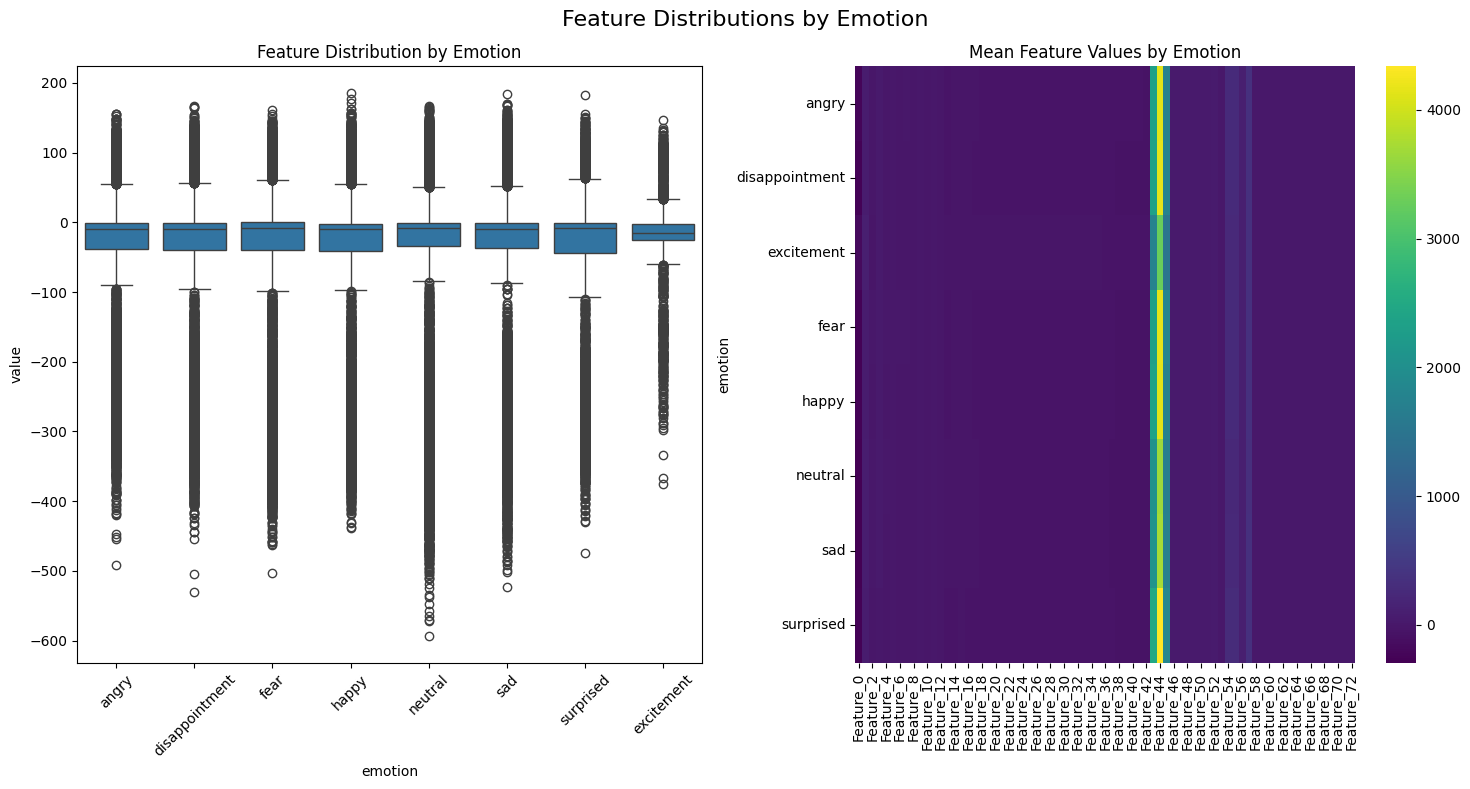


Top 10 Discriminative Features per Emotion:

NEUTRAL:
  Feature_44: 418.1676 (higher than average)
  Feature_43: 262.3027 (higher than average)
  Feature_45: 72.4821 (higher than average)
  Feature_0: 33.4522 (higher than average)
  Feature_55: 28.2184 (higher than average)
  Feature_54: 28.2029 (higher than average)
  Feature_1: 15.8145 (higher than average)
  Feature_2: 9.0636 (higher than average)
  Feature_57: 7.0768 (higher than average)
  Feature_13: 5.7864 (higher than average)

ANGRY:
  Feature_44: 148.4412 (higher than average)
  Feature_43: 71.1809 (higher than average)
  Feature_0: 40.7125 (higher than average)
  Feature_2: 7.0399 (higher than average)
  Feature_1: 7.0016 (higher than average)
  Feature_54: 6.7814 (higher than average)
  Feature_55: 6.7439 (higher than average)
  Feature_3: 3.9588 (higher than average)
  Feature_39: 3.7948 (higher than average)
  Feature_24: 3.7397 (higher than average)

SAD:
  Feature_44: 328.5294 (higher than average)
  Feature_43: 193.84

d:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "d:\Anaconda\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "d:\Anaconda\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


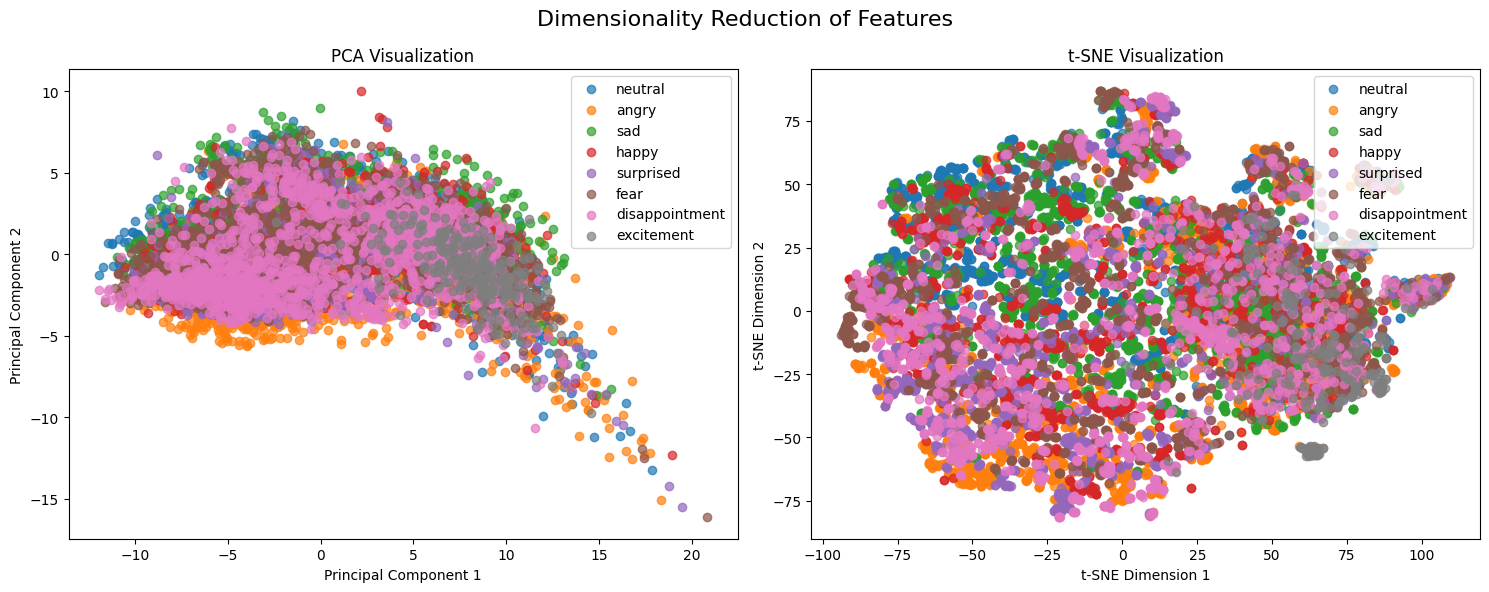

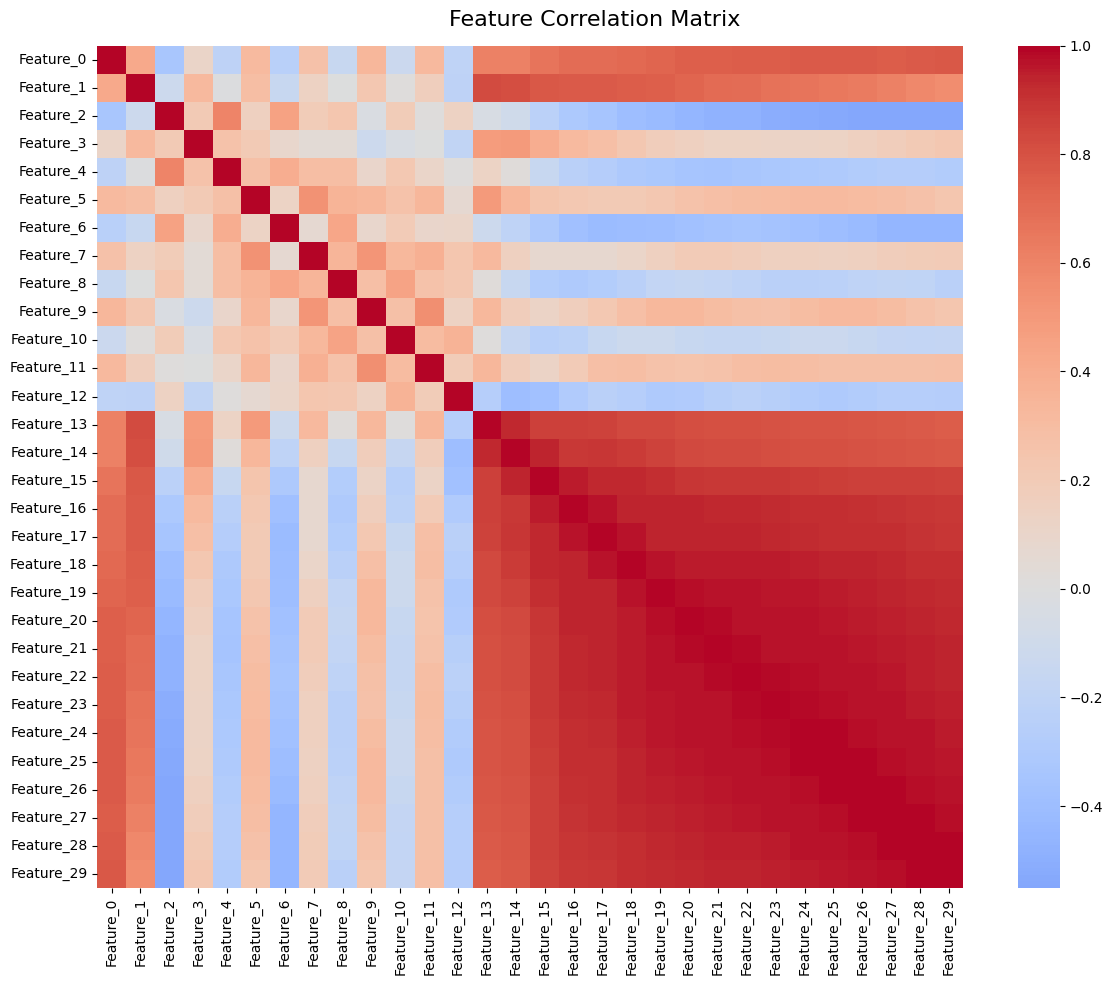


Analyzing Feature Groups:


<Figure size 1400x800 with 0 Axes>

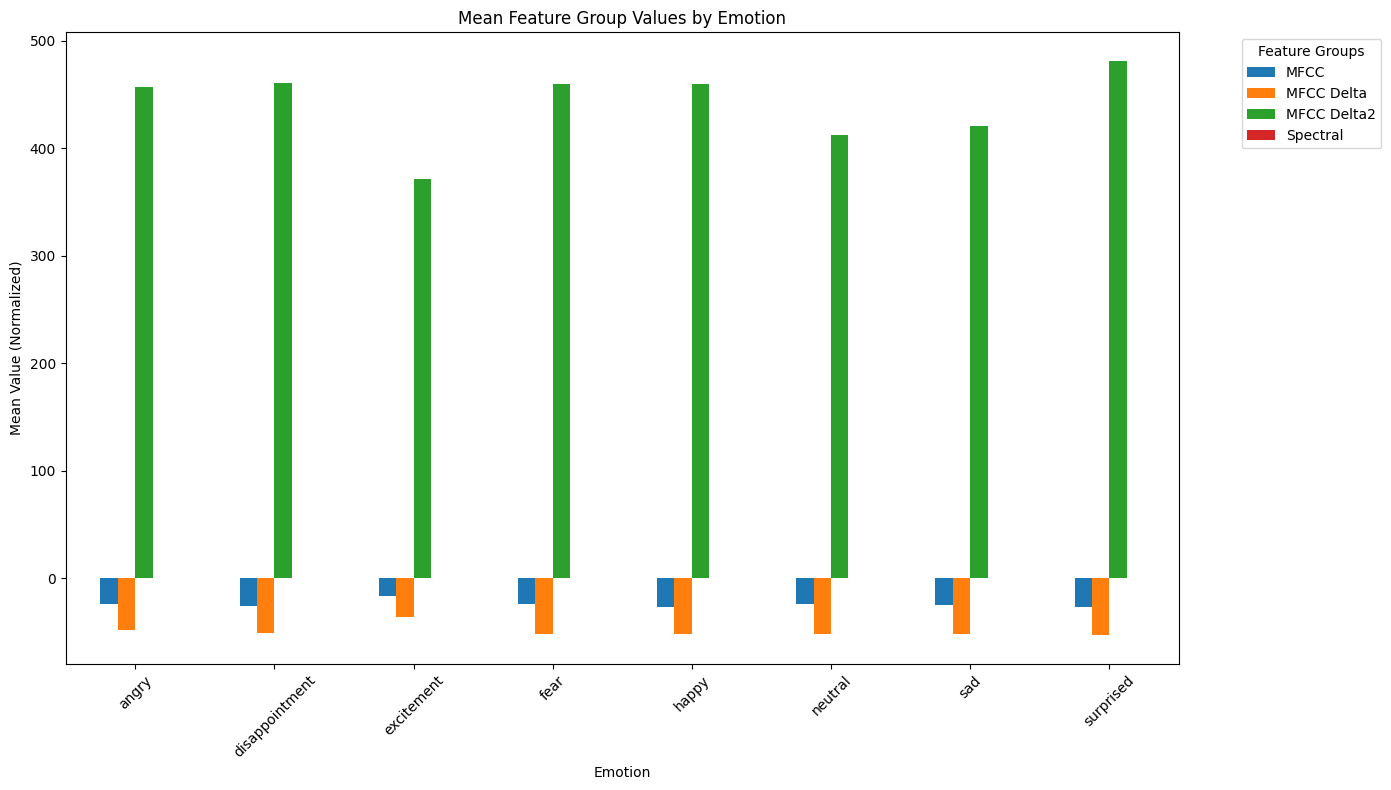


Most Discriminative Feature Groups per Emotion:

NEUTRAL:
  MFCC Delta2: 28.2190 (higher than average)
  MFCC Delta: 2.4194 (higher than average)
  MFCC: 0.1406 (higher than average)

ANGRY:
  MFCC Delta2: 16.3340 (higher than average)
  MFCC Delta: 1.4214 (higher than average)
  MFCC: 0.5183 (higher than average)

SAD:
  MFCC Delta2: 19.8774 (higher than average)
  MFCC Delta: 2.4461 (higher than average)
  MFCC: 0.9068 (higher than average)

HAPPY:
  MFCC Delta2: 19.6403 (higher than average)
  MFCC Delta: 2.4120 (higher than average)
  MFCC: 2.3009 (higher than average)

SURPRISED:
  MFCC Delta2: 40.9421 (higher than average)
  MFCC Delta: 3.2438 (higher than average)
  MFCC: 2.8046 (higher than average)

FEAR:
  MFCC Delta2: 19.3040 (higher than average)
  MFCC Delta: 2.0994 (higher than average)
  MFCC: 0.1216 (higher than average)

DISAPPOINTMENT:
  MFCC Delta2: 20.4164 (higher than average)
  MFCC Delta: 1.8506 (higher than average)
  MFCC: 1.8415 (higher than average)

EXCITEM

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

def visualize_features_per_emotion(all_features, labels, label_map, n_features_to_show=20):
    """
    Visualize the comprehensive features per emotion using multiple visualization techniques
    
    Args:
        all_features: List of feature arrays (each of shape [155, n_frames])
        labels: List of emotion labels for each sample
        label_map: Dictionary mapping emotion names to indices
        n_features_to_show: Number of top features to show in detailed plots
    """
    # Convert labels to indices
    label_indices = [label_map[emotion.lower()] for emotion in labels]
    emotions = list(label_map.keys())
    
    # Aggregate features per sample (mean across frames)
    aggregated_features = []
    for feat in all_features:
        # Take mean across time frames for each feature
        sample_mean = np.mean(feat, axis=1)
        aggregated_features.append(sample_mean)
    
    aggregated_features = np.array(aggregated_features)  # Shape: [n_samples, 155]
    
    # Create a DataFrame for easier manipulation
    feature_names = [f"Feature_{i}" for i in range(aggregated_features.shape[1])]
    df = pd.DataFrame(aggregated_features, columns=feature_names)
    df['emotion'] = [emotions[idx] for idx in label_indices]
    
    # 1. Overall feature distribution per emotion (Boxplot)
    plt.figure(figsize=(15, 8))
    plt.suptitle('Feature Distributions by Emotion', fontsize=16)
    
    # Select a subset of features for visualization
    selected_features = feature_names[:n_features_to_show]
    
    # Melt dataframe for seaborn
    df_melt = pd.melt(df, id_vars=['emotion'], value_vars=selected_features, 
                      var_name='feature', value_name='value')
    
    # Create boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='emotion', y='value', data=df_melt)
    plt.title('Feature Distribution by Emotion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 2. Mean feature values per emotion (Heatmap)
    plt.subplot(1, 2, 2)
    emotion_means = df.groupby('emotion').mean()
    sns.heatmap(emotion_means, cmap='viridis')
    plt.title('Mean Feature Values by Emotion')
    plt.tight_layout()
    
    plt.show()
    
    # 3. Top discriminative features per emotion
    print("\nTop 10 Discriminative Features per Emotion:")
    print("=" * 60)
    
    for emotion in emotions:
        # Get samples for this emotion
        emotion_data = df[df['emotion'] == emotion].drop('emotion', axis=1)
        other_data = df[df['emotion'] != emotion].drop('emotion', axis=1)
        
        # Calculate mean difference between this emotion and others
        emotion_mean = emotion_data.mean()
        other_mean = other_data.mean()
        mean_diff = emotion_mean - other_mean
        
        # Get top features with largest differences
        top_features = mean_diff.abs().sort_values(ascending=False).head(10)
        
        print(f"\n{emotion.upper()}:")
        for feature, diff in top_features.items():
            direction = "higher" if diff > 0 else "lower"
            print(f"  {feature}: {diff:.4f} ({direction} than average)")
    
    # 4. Dimensionality reduction visualization
    print("\nGenerating dimensionality reduction plots...")
    
    # Standardize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(aggregated_features)
    
    # PCA visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(15, 6))
    plt.suptitle('Dimensionality Reduction of Features', fontsize=16)
    
    plt.subplot(1, 2, 1)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    
    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(features_scaled)
    
    plt.subplot(1, 2, 2)
    for emotion in emotions:
        idx = [i for i, e in enumerate(df['emotion']) if e == emotion]
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=emotion, alpha=0.7)
    
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. Feature correlation heatmap
    plt.figure(figsize=(12, 10))
    plt.suptitle('Feature Correlation Matrix', fontsize=16)
    
    # Calculate correlation matrix for a subset of features
    corr_features = feature_names[:30]  # First 30 features
    corr_matrix = df[corr_features].corr()
    
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.tight_layout()
    plt.show()
    
    # 6. Feature group analysis
    print("\nAnalyzing Feature Groups:")
    print("=" * 60)
    
    # Define feature groups based on your extraction function
    feature_groups = {
        'MFCC': list(range(0, 20)),  # First 20 features: MFCCs
        'MFCC Delta': list(range(20, 40)),  # Next 20: MFCC deltas
        'MFCC Delta2': list(range(40, 60)),  # Next 20: MFCC delta2
        'Spectral': list(range(60, 101)),  # Spectral features (41 features)
        'Prosodic': list(range(101, 111)),  # Prosodic features (10 features)
        'VAD': list(range(111, 116)),  # VAD features (5 features)
        'Harmonic': list(range(116, 132)),  # Harmonic features (16 features)
        'Formant': list(range(132, 137)),  # Formant features (5 features)
        'Voice Quality': [137],  # HNR feature
        'Rhythm': list(range(138, 143)),  # Rhythm features (5 features)
        'Spectral Dynamics': list(range(143, 151)),  # Spectral dynamics (8 features)
        'Energy Dynamics': list(range(151, 155))  # Energy dynamics (4 features)
    }
    
    # Calculate mean value per group per emotion
    group_means = {}
    for group, indices in feature_groups.items():
        group_features = [feature_names[i] for i in indices if i < len(feature_names)]
        if group_features:
            group_data = df.groupby('emotion')[group_features].mean()
            group_means[group] = group_data.mean(axis=1)  # Mean across features in the group
    
    # Convert to DataFrame for easier plotting
    group_df = pd.DataFrame(group_means)
    
    # Plot feature group means
    plt.figure(figsize=(14, 8))
    group_df.plot(kind='bar', figsize=(14, 8))
    plt.title('Mean Feature Group Values by Emotion')
    plt.ylabel('Mean Value (Normalized)')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print most discriminative feature groups per emotion
    print("\nMost Discriminative Feature Groups per Emotion:")
    for emotion in emotions:
        emotion_values = group_df.loc[emotion]
        overall_mean = group_df.mean()
        diff = emotion_values - overall_mean
        top_groups = diff.abs().sort_values(ascending=False).head(3)
        
        print(f"\n{emotion.upper()}:")
        for group, diff_val in top_groups.items():
            direction = "higher" if diff_val > 0 else "lower"
            print(f"  {group}: {diff_val:.4f} ({direction} than average)")

# After extracting features and creating label_map, call the visualization function
print("\nVisualizing features per emotion...")
visualize_features_per_emotion(all_features, augmented_labels, label_map, n_features_to_show=20)

Initializing real-time optimized model...
Starting training...
🎯 Starting training with OneCycleLR and AMP
📊 Gap warning threshold = 0.12 | Early stopping patience = 20
Epoch  1/200 | Train: 0.171 | Val: 0.245 | Gap: 0.074 | Val F1: 0.172 | Time: 2.9s | LR: 0.000106
  ✓ New best model saved! Val Accuracy: 0.2451
Epoch  2/200 | Train: 0.229 | Val: 0.288 | Gap: 0.059 | Val F1: 0.204 | Time: 2.8s | LR: 0.000122
  ✓ New best model saved! Val Accuracy: 0.2878
Epoch  3/200 | Train: 0.250 | Val: 0.274 | Gap: 0.024 | Val F1: 0.194 | Time: 2.6s | LR: 0.000149
Epoch  4/200 | Train: 0.262 | Val: 0.299 | Gap: 0.036 | Val F1: 0.209 | Time: 2.6s | LR: 0.000186
  ✓ New best model saved! Val Accuracy: 0.2986
Epoch  5/200 | Train: 0.272 | Val: 0.303 | Gap: 0.031 | Val F1: 0.235 | Time: 2.5s | LR: 0.000232
  ✓ New best model saved! Val Accuracy: 0.3031
Epoch  6/200 | Train: 0.284 | Val: 0.286 | Gap: 0.002 | Val F1: 0.224 | Time: 2.6s | LR: 0.000286
Epoch  7/200 | Train: 0.298 | Val: 0.305 | Gap: 0.008 |

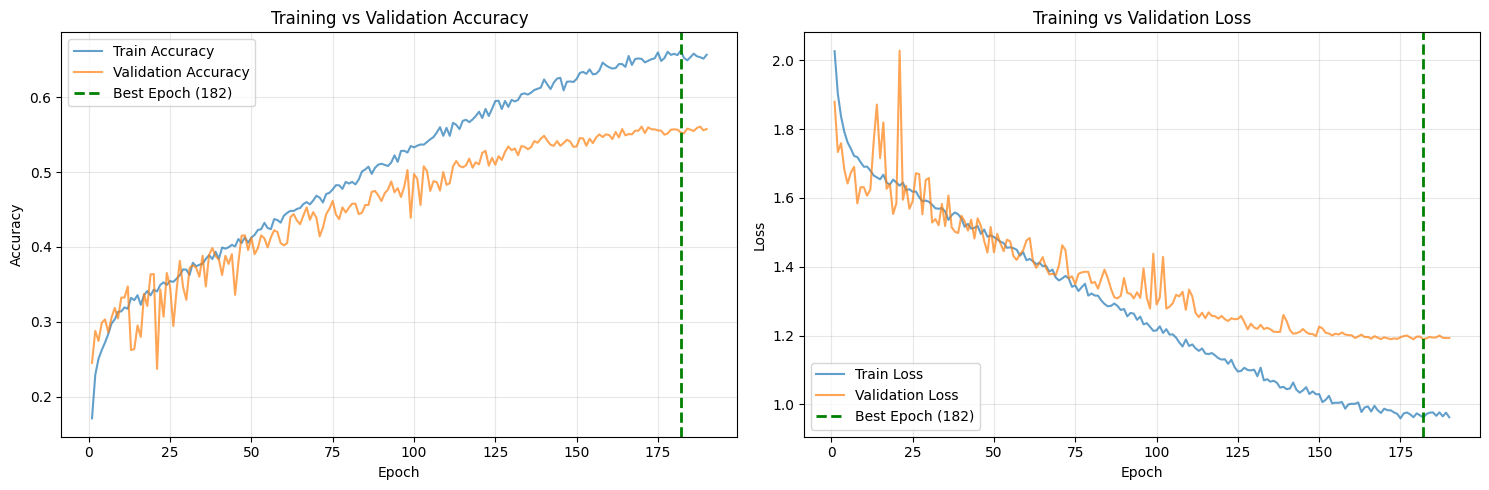

Best epoch: 182
Best validation loss: 1.1889
Best validation accuracy: 0.5531
✅ Training complete. Best validation accuracy: 0.5607
Final evaluation...
Evaluating model...
Test Accuracy: 0.6106

Classification Report:
                precision    recall  f1-score   support

       neutral       0.83      0.51      0.63       357
         angry       0.47      0.90      0.61       364
           sad       0.85      0.53      0.66       307
         happy       0.52      0.83      0.64       299
     surprised       0.73      0.75      0.74       255
          fear       0.66      0.50      0.57       286
disappointment       0.79      0.23      0.36       305
    excitement       0.52      0.67      0.58        51

      accuracy                           0.61      2224
     macro avg       0.67      0.61      0.60      2224
  weighted avg       0.68      0.61      0.60      2224



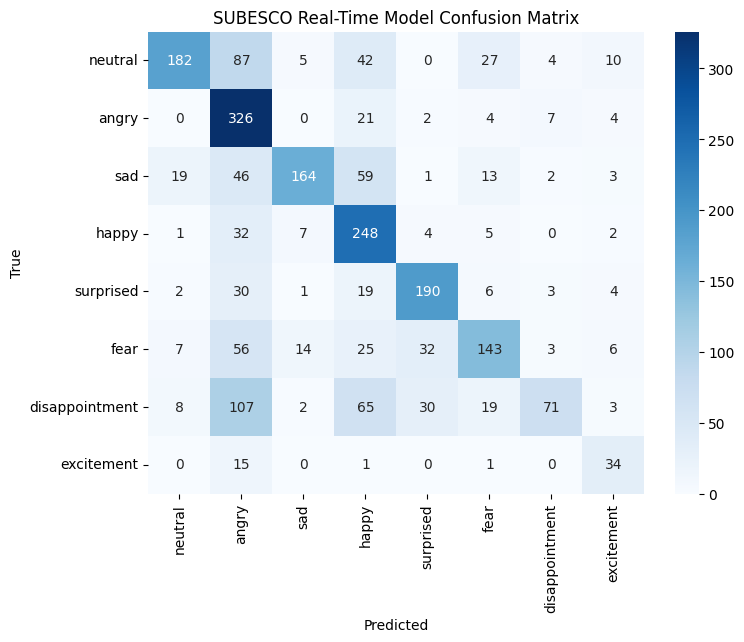


TRAINING COMPLETED!
Final Test Accuracy: 0.6106
Model saved as: SUBESCO_Realtime_Model.pth
Model parameters: 2,307,656


In [46]:
# Step 7: Initialize and train model

for i in range(1):
    print("Initializing real-time optimized model...")
    # model = RealtimeCNNTransformer(num_classes=config.NUM_CLASSES)
    model = EnhancedRealtimeCNNTransformer(num_classes=config.NUM_CLASSES)

    print("Starting training...")
    model = train_best_known_config(model, train_loader, val_loader)

    # Step 8: Evaluate model
    print("Final evaluation...")
    test_accuracy = evaluate_realtime_model(model, test_loader, label_map_inv)

print(f"\n" + "=" * 60)
print(f"TRAINING COMPLETED!")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: SUBESCO_Realtime_Model.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("=" * 60)

In [536]:
import torch
import os
import numpy as np
from sklearn.metrics import classification_report
import librosa
import soundfile as sf

def load_trained_model(model_path="SUBESCO_Realtime_Model.pth"):
    """Load the trained model"""
    model = RealtimeCNNTransformer(num_classes=config.NUM_CLASSES)
    model.load_state_dict(torch.load(model_path, map_location=config.DEVICE))
    model.to(config.DEVICE)
    model.eval()
    print(f"✅ Model loaded from {model_path}")
    return model

def test_audio_files(model, test_folder_path, show_details=True):
    """Test model on audio files in a folder"""
    
    # Emotion labels (adjust order to match your training)
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'excitement', 'disappointment']
    
    print(f"🎵 Testing audio files in: {test_folder_path}")
    print("=" * 60)
    
    results = []
    
    # Get all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a']
    audio_files = []
    
    for file in os.listdir(test_folder_path):
        if any(file.lower().endswith(ext) for ext in audio_extensions):
            audio_files.append(file)
    
    if not audio_files:
        print("❌ No audio files found in the specified folder!")
        return
    
    print(f"Found {len(audio_files)} audio files to test\n")
    
    with torch.no_grad():
        for i, filename in enumerate(audio_files, 1):
            file_path = os.path.join(test_folder_path, filename)
            
            try:
                # Extract features using your enhanced feature extraction
                features = extract_enhanced_realtime_features(file_path)  # Returns (80, n_frames)
                
                # Convert to tensor and add batch dimension
                features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)  # (1, 80, n_frames)
                
                # Make prediction
                outputs = model(features_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(outputs, dim=1).item()
                confidence = probabilities[0][predicted_class].item()
                
                predicted_emotion = emotion_labels[predicted_class]
                
                # Store results
                result = {
                    'filename': filename,
                    'predicted_emotion': predicted_emotion,
                    'confidence': confidence,
                    'all_probabilities': probabilities[0].cpu().numpy()
                }
                results.append(result)
                
                # Print results
                if show_details:
                    print(f"{i:2d}. {filename}")
                    print(f"    🎯 Predicted: {predicted_emotion.upper()} ({confidence:.3f})")
                    
                    # Show top 3 predictions
                    top3_indices = torch.topk(probabilities[0], 3).indices.cpu().numpy()
                    print("    📊 Top 3 predictions:")
                    for j, idx in enumerate(top3_indices):
                        emotion = emotion_labels[idx]
                        prob = probabilities[0][idx].item()
                        print(f"       {j+1}. {emotion}: {prob:.3f}")
                    print()
                else:
                    print(f"{i:2d}. {filename:<30} → {predicted_emotion.upper()} ({confidence:.3f})")
                    
            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")
                continue
    
    return results

def test_single_audio(model, audio_path):
    """Test a single audio file"""
    emotion_labels = ['neutral', 'angry', 'sad', 'happy', 'surprised', 'fear', 'excitement', 'disappointment']
    
    print(f"🎵 Testing single file: {os.path.basename(audio_path)}")
    print("=" * 50)
    
    try:
        # Extract features
        features = extract_enhanced_realtime_features(audio_path)
        features_tensor = torch.FloatTensor(features).unsqueeze(0).to(config.DEVICE)
        
        with torch.no_grad():
            outputs = model(features_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
            
            predicted_emotion = emotion_labels[predicted_class]
            
            print(f"🎯 Predicted Emotion: {predicted_emotion.upper()}")
            print(f"📈 Confidence: {confidence:.3f}")
            print("\n📊 All Emotion Probabilities:")
            
            # Sort by probability
            sorted_indices = torch.argsort(probabilities[0], descending=True).cpu().numpy()
            
            for i, idx in enumerate(sorted_indices):
                emotion = emotion_labels[idx]
                prob = probabilities[0][idx].item()
                bar = "█" * int(prob * 20)  # Simple bar chart
                print(f"   {emotion:<12}: {prob:.3f} {bar}")
                
        return predicted_emotion, confidence
        
    except Exception as e:
        print(f"❌ Error processing file: {e}")
        return None, None

def batch_test_with_summary(model, test_folder_path):
    """Test folder and provide summary statistics"""
    results = test_audio_files(model, test_folder_path, show_details=False)
    
    if not results:
        return
    
    print(f"\n📈 TESTING SUMMARY")
    print("=" * 40)
    
    # Count predictions by emotion
    emotion_counts = {}
    confidence_by_emotion = {}
    
    for result in results:
        emotion = result['predicted_emotion']
        confidence = result['confidence']
        
        if emotion not in emotion_counts:
            emotion_counts[emotion] = 0
            confidence_by_emotion[emotion] = []
        
        emotion_counts[emotion] += 1
        confidence_by_emotion[emotion].append(confidence)
    
    # Print summary
    total_files = len(results)
    print(f"Total files tested: {total_files}")
    print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")
    print("\nEmotion Distribution:")
    
    for emotion, count in sorted(emotion_counts.items()):
        percentage = (count / total_files) * 100
        avg_confidence = np.mean(confidence_by_emotion[emotion])
        print(f"  {emotion:<12}: {count:2d} files ({percentage:4.1f}%) - Avg confidence: {avg_confidence:.3f}")
    
    # Find high and low confidence predictions
    high_confidence = [r for r in results if r['confidence'] > 0.8]
    low_confidence = [r for r in results if r['confidence'] < 0.5]
    
    print(f"\nHigh confidence predictions (>0.8): {len(high_confidence)}")
    print(f"Low confidence predictions (<0.5): {len(low_confidence)}")
    
    if low_confidence:
        print("\n⚠️  Low confidence files:")
        for result in low_confidence:
            print(f"   {result['filename']}: {result['predicted_emotion']} ({result['confidence']:.3f})")


"""Main testing interface"""
print("🤖 Emotion Recognition Model Tester")
print("=" * 60)

# Load model
model = load_trained_model("SUBESCO_Realtime_Model.pth")

while True:
    print("\nChoose testing option:")
    print("1. Test single audio file")
    print("2. Test all files in a folder (detailed)")
    print("3. Test all files in a folder (summary)")
    print("4. Exit")
    
    choice = input("\nEnter your choice (1-4): ")
    
    if choice == '1':
        audio_path = input("Enter audio file path: ")
        if os.path.exists(audio_path):
            test_single_audio(model, audio_path)
        else:
            print("❌ File not found!")
            
    elif choice == '2':
        folder_path = input("Enter folder path: ")
        if os.path.exists(folder_path):
            test_audio_files(model, folder_path, show_details=True)
        else:
            print("❌ Folder not found!")
            
    elif choice == '3':
        folder_path = input("Enter folder path: ")
        if os.path.exists(folder_path):
            batch_test_with_summary(model, folder_path)
        else:
            print("❌ Folder not found!")
            
    elif choice == '4':
        print("👋 Goodbye!")
        break
    else:
        print("❌ Invalid choice!")


🤖 Emotion Recognition Model Tester
✅ Model loaded from SUBESCO_Realtime_Model.pth

Choose testing option:
1. Test single audio file
2. Test all files in a folder (detailed)
3. Test all files in a folder (summary)
4. Exit
🎵 Testing audio files in: C:\Users\guyaw\Desktop\CSE499 Research papers\Jupiter\7-Emotion-Bangla-Speech-Recognition-Model\Testing
Found 8 audio files to test

 1. 0070_surprised.wav
    🎯 Predicted: EXCITEMENT (0.292)
    📊 Top 3 predictions:
       1. excitement: 0.292
       2. angry: 0.290
       3. happy: 0.169

 2. 0236_sad.wav
    🎯 Predicted: ANGRY (0.503)
    📊 Top 3 predictions:
       1. angry: 0.503
       2. fear: 0.240
       3. happy: 0.113

 3. 0452_neutral.wav
    🎯 Predicted: ANGRY (0.385)
    📊 Top 3 predictions:
       1. angry: 0.385
       2. disappointment: 0.227
       3. happy: 0.159

 4. 0655_angry.wav
    🎯 Predicted: ANGRY (0.409)
    📊 Top 3 predictions:
       1. angry: 0.409
       2. happy: 0.256
       3. fear: 0.087

 5. 1891_disappoint

KeyboardInterrupt: Interrupted by user